In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt


2024-08-20 12:11:08.449299: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 12:11:08.580924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 12:11:08.638812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 12:11:08.654847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 12:11:08.744840: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# 하이퍼 파라미터 설정
lr = 1e-3
batch_size = 3
num_epoch = 100

data_dir = "./datasets"
ckpt_dir = "./checkpoint"
log_dir = "./log"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 네트워크 구축
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # cbr2d가 무엇인가 3개의 레이어를 하나의 함수로 묶은것
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            # convolution layer 정의
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            # batch normaliztion layer 정의
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            # relu layer 정의
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            print(cbr)

            return cbr
        
        # contracting path
        # 제일 첫 화살표이고 중심을 기준으로 좌측이 엔코더이므로 enc 1번째의 stage의 첫번쩨 화살표
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=1, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0)

    # x = 입력 이미지
    def forward(self, x):
        # 인코더 스테이지
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc1_1(pool1)
        enc2_2 = self.enc1_2(enc2_1)
        pool2 = self.pool1(enc2_2)

        enc3_1 = self.enc1_1(pool2)
        enc3_2 = self.enc1_2(enc3_1)
        pool3 = self.pool1(enc3_2)

        enc4_1 = self.enc1_1(pool3)
        enc4_2 = self.enc1_2(enc4_1)
        pool4 = self.pool1(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        # 디코더 스테이지
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.concat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.concat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec4_2(cat3)
        dec3_1 = self.dec4_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.concat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec4_2(cat2)
        dec2_1 = self.dec4_1(dec2_2)

        unpool1 = self.unpool2(dec2_1)
        cat1 = torch.concat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec4_2(cat1)
        dec1_1 = self.dec4_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [3]:
from torchvision import transforms, datasets

# transform = transforms.Compose({
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
# })

# 데이터 로더 구현

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transfrom=None):
        self.data_dir = data_dir
        self.transform = transfrom

        lst_data = os.listdir(self.data_dir)

        lst_img = [f for f in lst_data if f.startswith("img")]
        lst_mask = [f for f in lst_data if f.startswith("mask")]

        lst_img.sort()
        lst_mask.sort()

        self.lst_img = lst_img
        self.lst_mask = lst_mask

    def __len__(self):
        return len(self.lst_mask)
    
    def __getitem__(self, index):
        img = np.load(os.path.join(self.data_dir, self.lst_img[index]))
        mask = np.load(os.path.join(self.data_dir, self.lst_mask[index]))

        # normalization
        img = img/255.0
        mask = mask/255.0

        if img.ndim == 2:
            img = img[:, :, np.newaxis]
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]
            # 같은 효과니까 나중에 확인해보기
            # lable = torch.unsqueeze(label, dim=-1)

        data = {"img" : img, "mask" : mask}

        if self.transform:
            data = self.transform(data)
        
        return data

In [18]:
dataset_train = Dataset(data_dir="./dataset/train/")

In [19]:
data = dataset_train.__getitem__(0)

img = data["img"]
mask = data["mask"]

In [20]:
img.shape

(512, 512, 3)

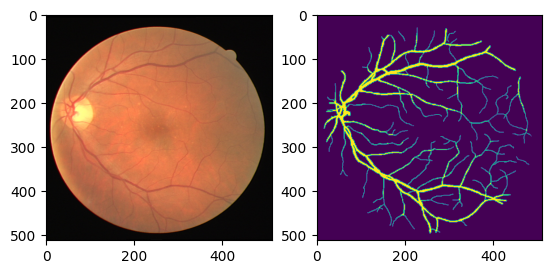

In [10]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(img.squeeze())

plt.subplot(122)
plt.imshow(mask.squeeze())

plt.show()

In [13]:
# 트랜스폼 함수 구현
class ToTensor(object):
    def __call__(self, data):
        img, mask = data["img"], data["mask"]
        img = img.transpose((2, 0, 1)).astype(np.float32)
        mask = mask.transpose((2, 0, 1)).astype(np.float32)

        data = {"img" : torch.from_numpy(img), "mask" : torch.from_numpy(mask)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        img, mask = data["img"], data["mask"]

        img = (img - self.mean) / self.std

        data = {"img" : img, "mask" : mask}

        return data
    
class RandomFlip(object):
    def __call__(self, data):
        img, mask = data["img"], data["mask"]

        if np.random.rand() > 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)

        if np.random.rand() > 0.5:
            img = np.flipud(img)
            mask = np.flipud(mask)

        data = {"img" : img, "mask" : mask}

        return data



In [45]:
transform = transforms.Compose({
    Normalization(mean=0.5, std=0.5),
    RandomFlip(),
    ToTensor()
})

dataset_train = Dataset(data_dir="./dataset/train/", transfrom=transform)
data = dataset_train.__getitem__(0)

img = data["img"]
mask = data["mask"]

In [46]:
print(img.shape)
print(mask.shape)
print(type(img))


torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


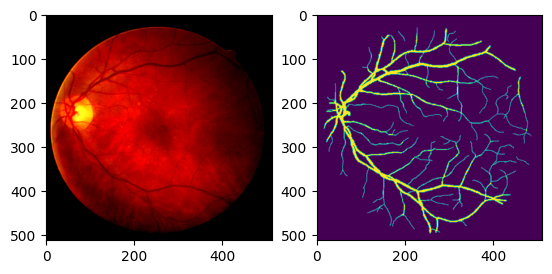

In [47]:
img = img.numpy().transpose((1,2,0))
print(img.shape)

plt.subplot(121)
plt.imshow(img.squeeze())

plt.subplot(122)
plt.imshow(mask.squeeze())

plt.show()